In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
batch_size = 32

In [3]:
filename = 'contest_dataset.npz'
dataset = np.load(filename)

In [4]:
inputs_denoise = dataset['inputs']
labels_denoise = dataset['labels']

In [5]:
class AutoEncoder_dataset(Dataset):
    def __init__(self, inputs):
        self.inputs = torch.from_numpy(inputs).float()
    
    def __getitem__(self, index):
        inputs = self.inputs[index]
        return inputs
    
    def __len__(self):
        return len(self.inputs)

In [6]:
contest_set = AutoEncoder_dataset(inputs = inputs_denoise)

In [7]:
contest_loader = DataLoader(dataset=contest_set,
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False)

In [8]:
class SegNet(nn.Module):
    
    def __init__(self):
        super(SegNet, self).__init__()
        
        # Encoder
        
        self.Enc_0_1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_2_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels= 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_3_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_4_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Enc_4_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder
        
        self.Dec_4_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_4_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_3_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_3_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_2_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_2_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_1_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.Dec_0_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU(inplace=True)
        )
        
        self.Unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        
    def forward(self, inputs):
        
        # Encoder
        
        dim_0 = inputs.size()
        outputs = self.Enc_0_1(inputs)
        outputs, indice_0 = self.Pool(outputs)
        
        dim_1 = outputs.size()
        outputs = self.Enc_1_1(outputs)
        outputs, indice_1 = self.Pool(outputs)
        
        dim_2 = outputs.size()
        outputs = self.Enc_2_1(outputs)
        outputs = self.Enc_2_2(outputs)
        outputs, indice_2 = self.Pool(outputs)
        
        dim_3 = outputs.size()
        outputs = self.Enc_3_1(outputs)
        outputs = self.Enc_3_2(outputs)
        outputs, indice_3 = self.Pool(outputs)
        
        dim_4 = outputs.size()
        outputs = self.Enc_4_1(outputs)
        outputs = self.Enc_4_2(outputs)
        outputs, indice_4 = self.Pool(outputs)
        
        dim_middle = outputs.size()
        
        # Decoder
        outputs = self.Unpool(outputs, indice_4, output_size=dim_4)
        outputs = self.Dec_4_2(outputs)
        outputs = self.Dec_4_1(outputs)
        dim_4d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_3, output_size=dim_3)
        outputs = self.Dec_3_2(outputs)
        outputs = self.Dec_3_1(outputs)
        dim_3d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_2, output_size=dim_2)
        outputs = self.Dec_2_2(outputs)
        outputs = self.Dec_2_1(outputs)
        dim_2d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_1, output_size=dim_1)
        outputs = self.Dec_1_1(outputs)
        dim_1d = outputs.size()
        
        outputs = self.Unpool(outputs, indice_0, output_size=dim_0)
        outputs = self.Dec_0_1(outputs)
        dim_0d = outputs.size()
        
        return outputs
        

In [9]:
GPU_NUM = 3
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Currernt cuda device ', torch.cuda.current_device())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Currernt cuda device  3
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
net = SegNet().to(device)

In [11]:
PATH = 'SegNet.pt'

In [12]:
checkpoint = torch.load(PATH, map_location=device)
net.load_state_dict(checkpoint['State_dict'])

<All keys matched successfully>

In [13]:
outputs_test = torch.FloatTensor(1, 2, 257, 382)

net.eval()

with torch.no_grad():
    for data in contest_loader:
        inputs = data
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs_test = torch.cat((outputs_test, outputs.to('cpu')), 0)

outputs_test = outputs_test[1:].numpy()

In [15]:
print(outputs_test.shape)
print(inputs_denoise.shape)

(500, 2, 257, 382)
(500, 2, 257, 382)


In [19]:
np.where(labels_denoise == 10)

(array([  3,  14,  17,  22,  25,  38,  61,  72,  82,  89,  90,  91,  96,
         97, 102, 117, 120, 124, 129, 142, 144, 149, 170, 172, 174, 176,
        178, 179, 184, 193, 194, 195, 197, 200, 202, 214, 215, 216, 217,
        220, 221, 225, 231, 232, 233, 236, 245, 253, 262, 266, 275, 285,
        293, 297, 303, 304, 308, 311, 314, 322, 328, 332, 335, 343, 345,
        364, 372, 379, 380, 384, 387, 395, 398, 399, 400, 416, 434, 436,
        445, 455, 457, 469, 476, 479, 487, 494, 496]),)

In [16]:
import matplotlib.pyplot as plt

Index :  382


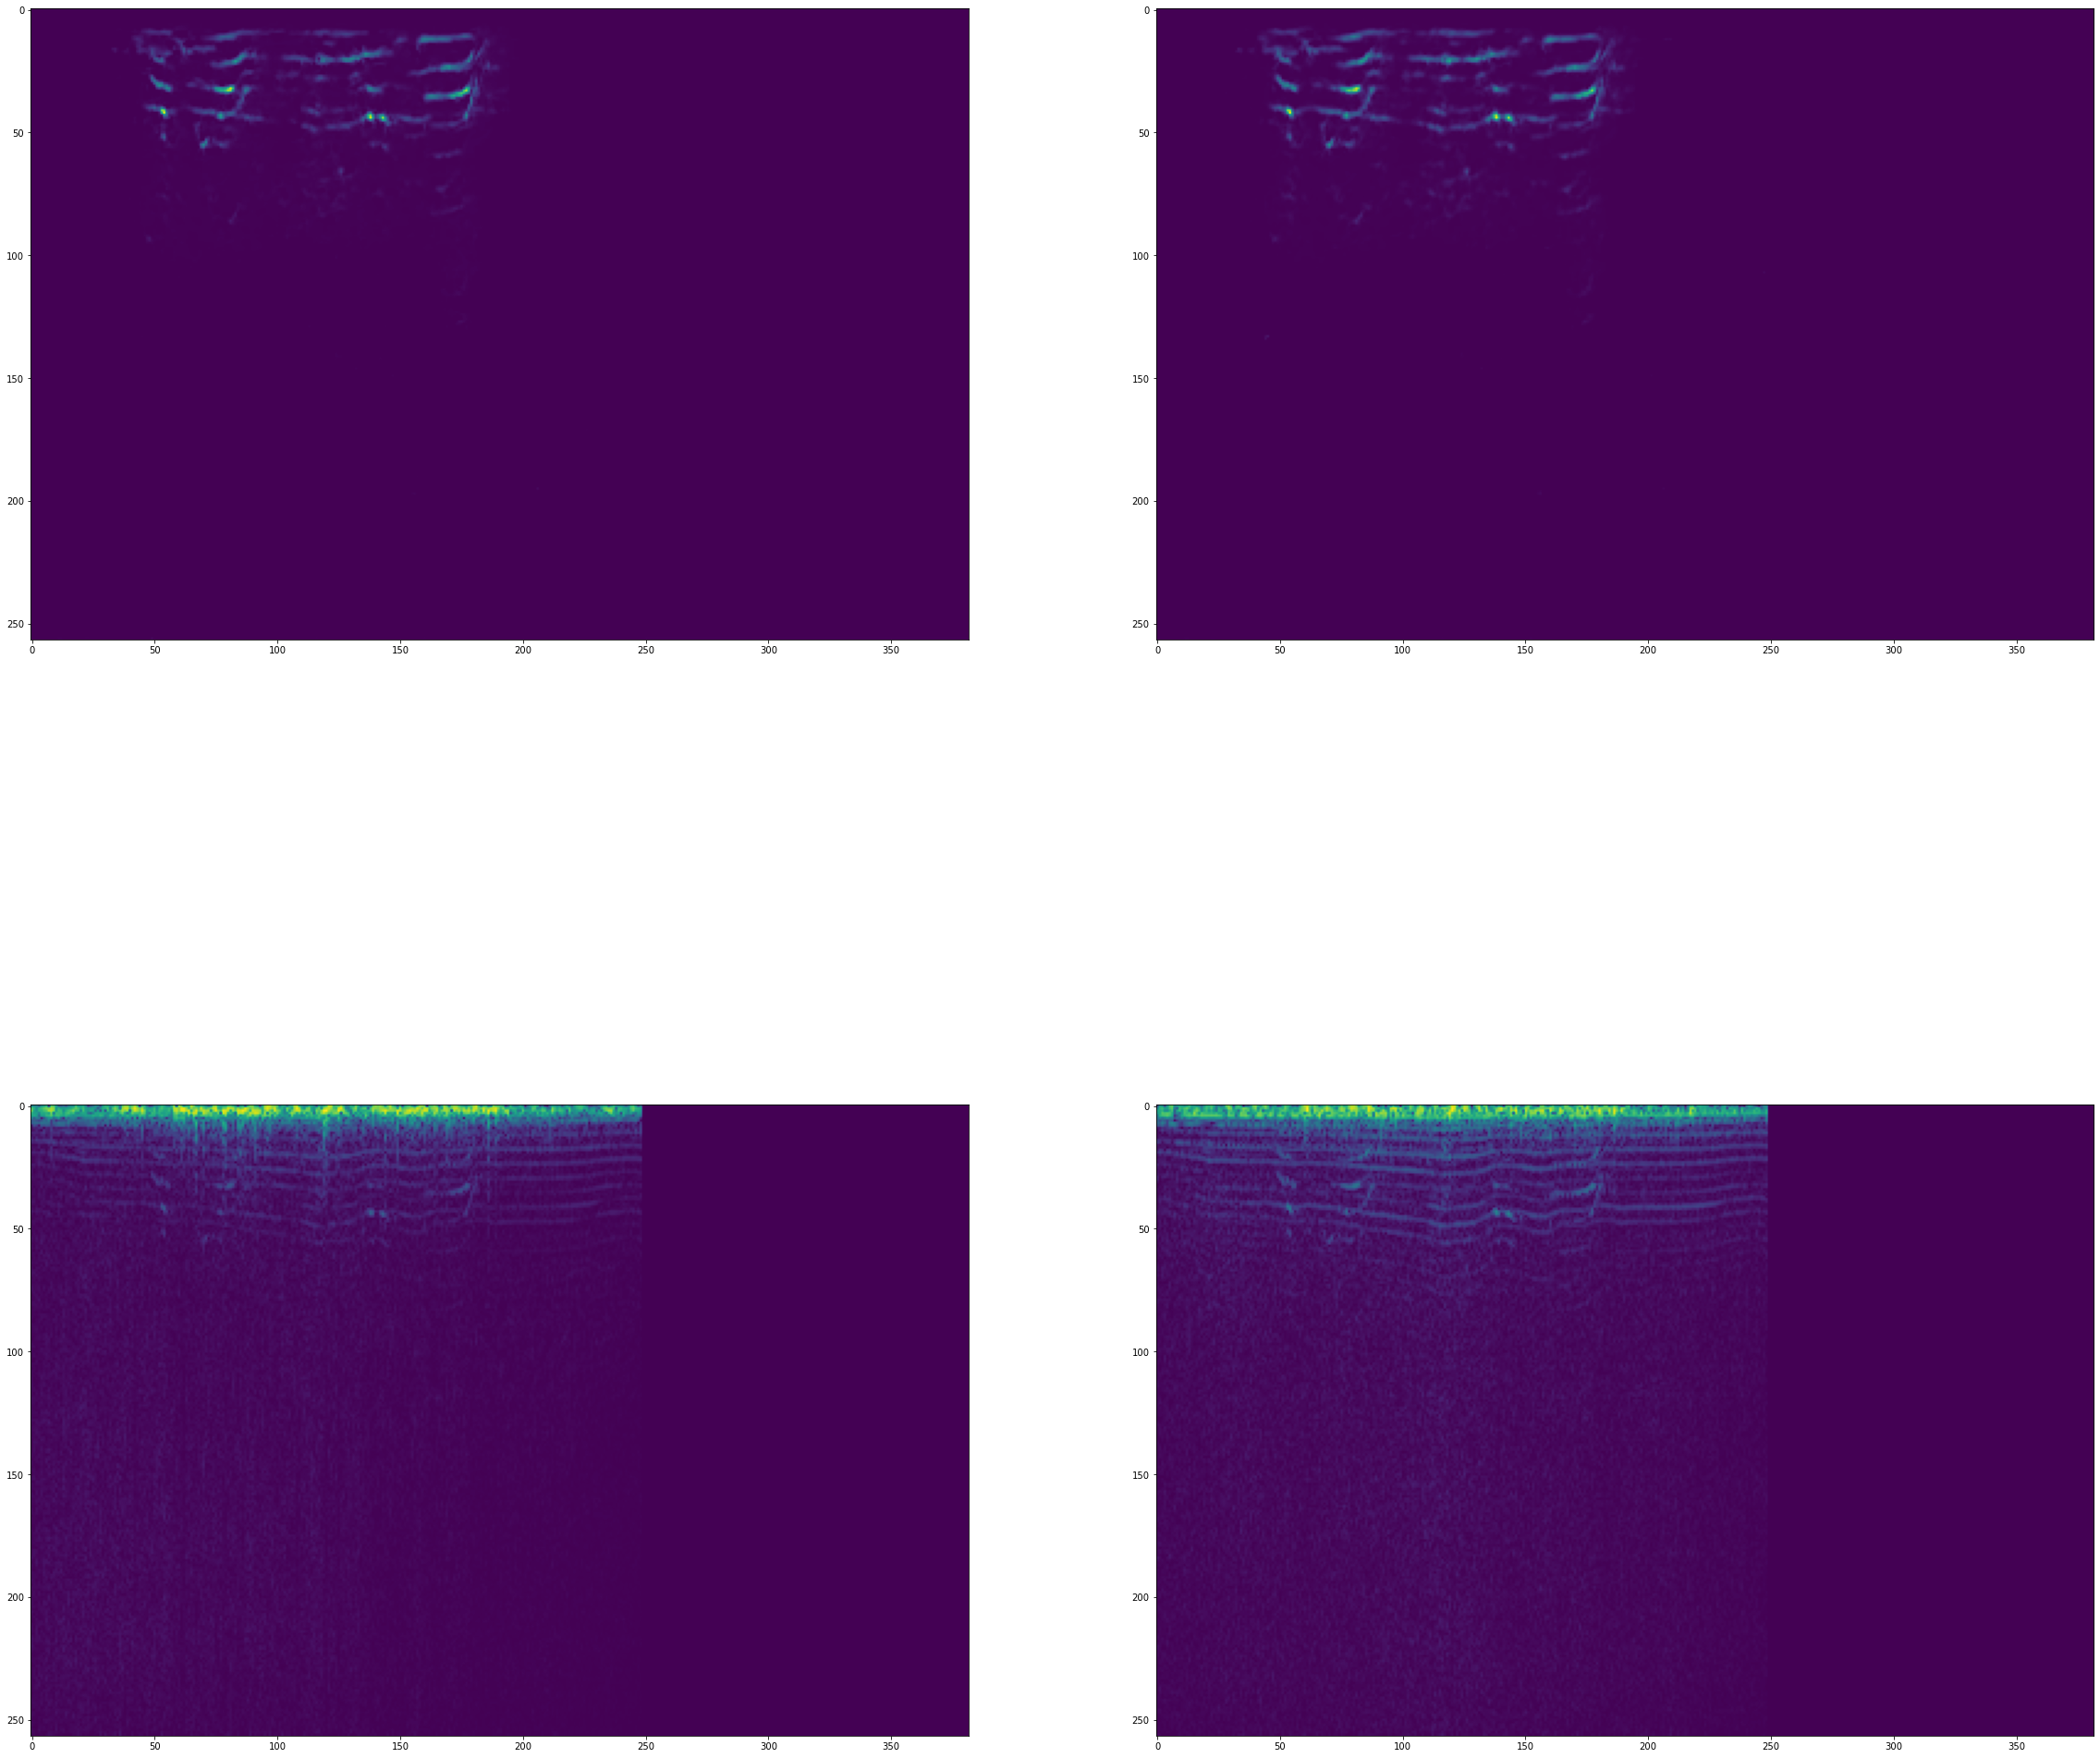

In [31]:
index = np.random.randint(0, 500)

print("Index : ", index)

fig = plt.figure(figsize=(40,40))

fig1 = fig.add_subplot(2, 2, 1)
fig1.imshow(outputs_test[index, 1])

fig2 = fig.add_subplot(2, 2, 2)
fig2.imshow(outputs_test[index, 0])

fig3 = fig.add_subplot(2, 2, 3)
fig3.imshow(inputs_denoise[index, 1])

fig4 = fig.add_subplot(2, 2, 4)
fig4.imshow(inputs_denoise[index, 0])

In [33]:
np.savez_compressed('contest_noise_removed',
                    inputs_contest=outputs_test,
                    labels_contest=labels_denoise)